In [30]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import zipfile
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder

In [31]:
img_width, img_height, channels = 150, 150, 3

transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])
main = '/content/Cats_And_Dogs_Dataset/Cats_and_Dogs'
train = datasets.ImageFolder(root=main + '/train', transform=transform)
val = datasets.ImageFolder(root=main + '/val', transform=transform)
test = datasets.ImageFolder(root=main + '/test', transform=transform)

img_width, img_height, channels = 150, 150, 3

input_shape = (img_width, img_height, 3)


batch_size = 64
nb_train_samples = 20000
nb_validation_samples = 2490
nb_test_samples = 2500

train_steps_per_epoch = nb_train_samples // batch_size
val_steps_per_epoch = nb_validation_samples // batch_size


train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers = 4)
val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers = 4)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [33]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding = 1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride = 2)

        # Layer 2
        self.conv2 = nn.Conv2d(16,32,3,1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2,2)

        # Layer 3
        self.conv3 = nn.Conv2d(32,64,3,1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(2,2)

        # Flatten
        self.flatten = nn.Flatten()

        # Fully connected layer
        self.fc1 = nn.Linear(64 * 17 * 17, 64)
        self.relu4 = nn.ReLU()

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

        # Fully connected layer
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # Layer 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # Layer 3
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = x.view(x.size(0), -1)

        # Fully connected layer 1
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)

        # Fully Connected layer 2
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

model = CNNModel()

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 5/20
Training Loss: 0.4691 - Training Accuracy: 0.7823
Validation Loss: 0.4506 - Validation Accuracy: 0.7888



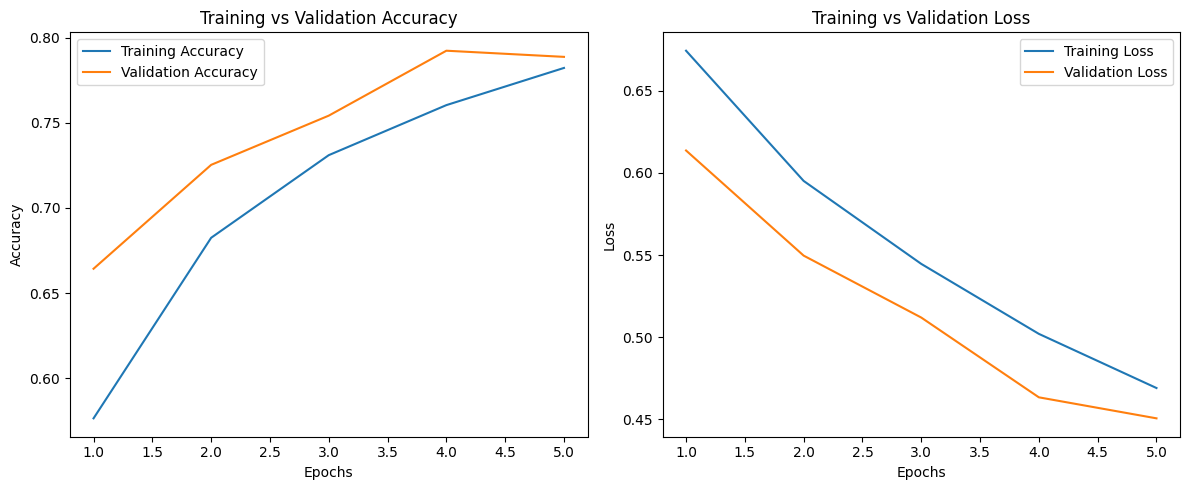

Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 10/20
Training Loss: 0.3819 - Training Accuracy: 0.8324
Validation Loss: 0.3885 - Validation Accuracy: 0.8281



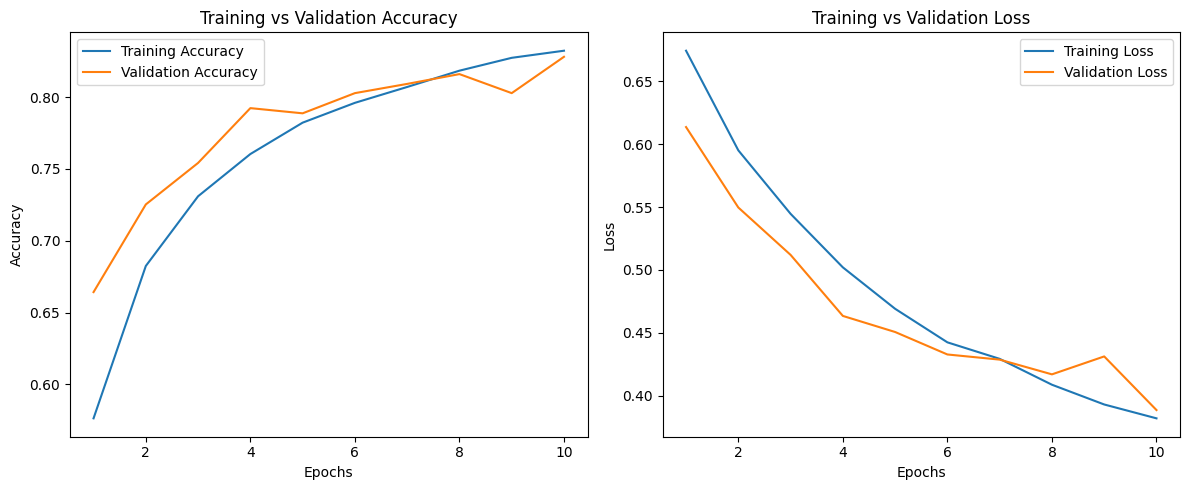

Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 15/20
Training Loss: 0.3319 - Training Accuracy: 0.8587
Validation Loss: 0.3536 - Validation Accuracy: 0.8349



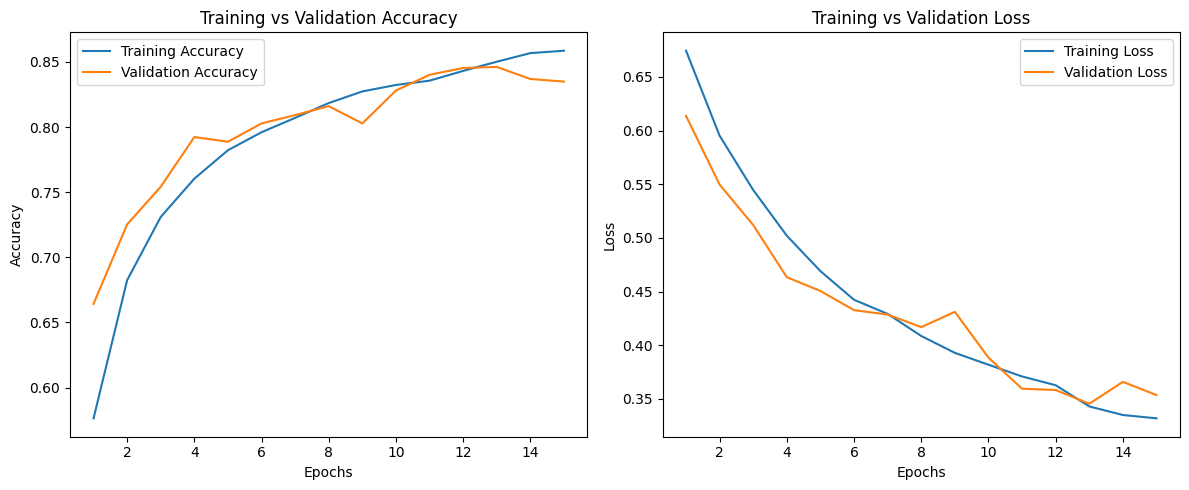

Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 20/20
Training Loss: 0.2922 - Training Accuracy: 0.8749
Validation Loss: 0.3411 - Validation Accuracy: 0.8486



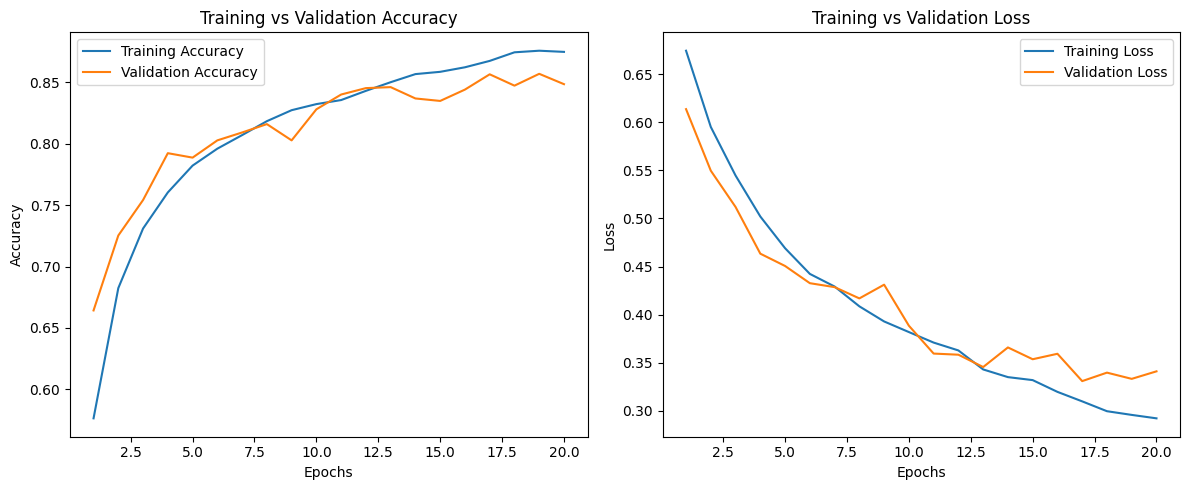

Test Loss: 0.3721
Test Accuracy: 0.8556


In [34]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

num_epochs = 20
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    print(f"Epoch {epoch + 1}/{num_epochs}")

    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted_labels = (outputs >= 0.5).float()
        correct_predictions += (predicted_labels == labels.view(-1, 1)).sum().item()
        total_samples += len(labels)

    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct_predictions / total_samples
    train_loss_list.append(epoch_loss)
    train_accuracy_list.append(epoch_accuracy)

    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    with torch.no_grad():
        for batch_idx, (val_images, val_labels) in enumerate(val_dataloader):
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels.float().view(-1, 1))
            val_running_loss += val_loss.item()
            val_predicted_labels = (val_outputs >= 0.5).float()
            val_correct_predictions += (val_predicted_labels == val_labels.view(-1, 1)).sum().item()
            val_total_samples += len(val_labels)

    val_epoch_loss = val_running_loss / len(val_dataloader)
    val_epoch_accuracy = val_correct_predictions / val_total_samples
    val_loss_list.append(val_epoch_loss)
    val_accuracy_list.append(val_epoch_accuracy)

    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Training Loss: {epoch_loss:.4f} - Training Accuracy: {epoch_accuracy:.4f}")
        print(f"Validation Loss: {val_epoch_loss:.4f} - Validation Accuracy: {val_epoch_accuracy:.4f}\n")

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, epoch + 2), train_accuracy_list, label='Training Accuracy')
        plt.plot(range(1, epoch + 2), val_accuracy_list, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training vs Validation Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epoch + 2), train_loss_list, label='Training Loss')
        plt.plot(range(1, epoch + 2), val_loss_list, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training vs Validation Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

model.eval()
test_running_loss = 0.0
test_correct_predictions = 0
test_total_samples = 0

with torch.no_grad():
    for test_images, test_labels in test_dataloader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        test_outputs = model(test_images)
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        test_running_loss += test_loss.item()
        test_predicted_labels = (test_outputs >= 0.5).float()
        test_correct_predictions += (test_predicted_labels == test_labels.view(-1, 1)).sum().item()
        test_total_samples += len(test_labels)

# test loss and accuracy
test_epoch_loss = test_running_loss / len(test_dataloader)
test_epoch_accuracy = test_correct_predictions / test_total_samples

print(f"Test Loss: {test_epoch_loss:.4f}")
print(f"Test Accuracy: {test_epoch_accuracy:.4f}")
